
---

### Dataset yang dipakai:
1. Dataset [Data Pinjaman] - Sumber [https://www.kaggle.com/datasets/ardykaaw/data-pinjaman]
---

### Codingan :

In [115]:
# --- 1. DATA PREPARATION ---
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

In [117]:
# Load dataset
df = pd.read_csv("DATA PINJAMAN.csv")

In [119]:
# Drop ID column jika ada
if 'ID_Nasabah' in df.columns:
    df.drop(columns=["ID_Nasabah"], inplace=True)

In [121]:
# Pisahkan kolom numerik dan kategorik
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

In [123]:
# Imputasi nilai hilang
df[num_cols] = SimpleImputer(strategy="mean").fit_transform(df[num_cols])
df[cat_cols] = SimpleImputer(strategy="most_frequent").fit_transform(df[cat_cols])

In [125]:
# Encoding kategori
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

<Axes: xlabel='StatusPinjaman', ylabel='count'>

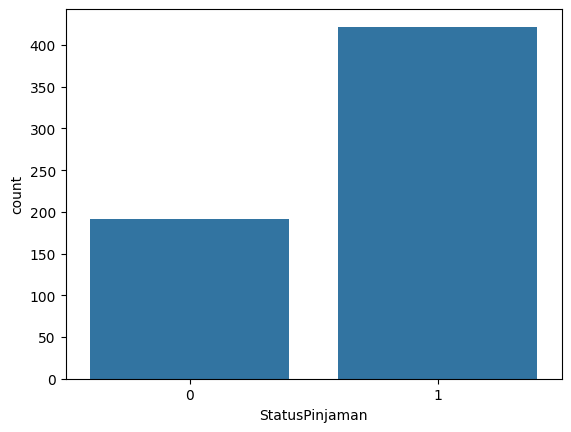

In [127]:
# --- 2. DATA TRANSFORMASI & SPLITTING ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.countplot(x=y)

In [133]:
# Pisahkan fitur dan target
X = df.drop("StatusPinjaman", axis=1)
y = df["StatusPinjaman"]

In [135]:
# Normalisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [137]:
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Menambahkan Smote
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [139]:
# Split data (Training dan Testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [141]:
# --- 3. MODEL BUILDING ---
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [143]:
# Model XGBoost (tanpa use_label_encoder)
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

In [145]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_res, y_train_res)
best_model = grid.best_estimator_

Fitting 3 folds for each of 32 candidates, totalling 96 fits


In [146]:
# Model lain sebagai pembanding: Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [149]:
# --- 4. EVALUASI MODEL ---
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

In [153]:
# Prediksi dan evaluasi XGBoost
y_pred_xgb = best_xgb.predict(X_test)
print("=== Evaluasi XGBoost ===")
print("Akurasi:", accuracy_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

=== Evaluasi XGBoost ===
Akurasi: 0.8373983739837398
Confusion Matrix:
 [[21 17]
 [ 3 82]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.55      0.68        38
           1       0.83      0.96      0.89        85

    accuracy                           0.84       123
   macro avg       0.85      0.76      0.78       123
weighted avg       0.84      0.84      0.83       123



In [155]:
# Cross Validation
cv_scores = cross_val_score(best_xgb, X_scaled, y, cv=5)
print("Cross Validation Accuracy:", np.round(cv_scores, 3))
print("Rata-rata Akurasi:", round(cv_scores.mean(), 3))

Cross Validation Accuracy: [0.813 0.772 0.78  0.854 0.82 ]
Rata-rata Akurasi: 0.808


In [157]:
# Evaluasi model pembanding: Random Forest
y_pred_rf = rf_model.predict(X_test)
print("\n=== Evaluasi Random Forest ===")
print("Akurasi:", accuracy_score(y_test, y_pred_rf))


=== Evaluasi Random Forest ===
Akurasi: 0.8292682926829268


<Figure size 1000x600 with 0 Axes>

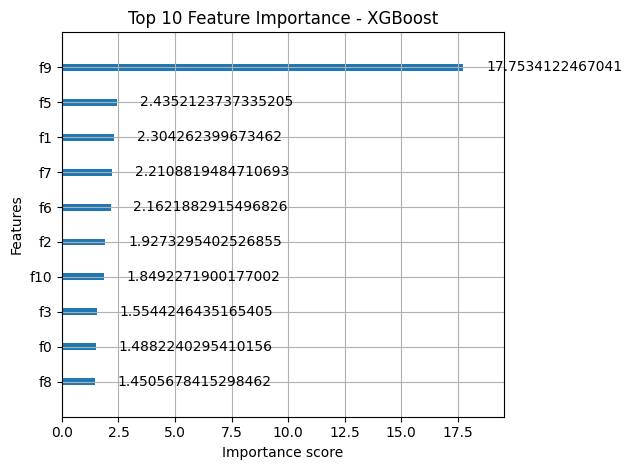

In [159]:
# Visualisasi Feature Importance
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(best_xgb, importance_type='gain', max_num_features=10)
plt.title("Top 10 Feature Importance - XGBoost")
plt.tight_layout()
plt.show()